In [3]:
# !pip install matplotlib pandas wordcloud
import os
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from dotenv import load_dotenv
load_dotenv()

print(_find_spark_home())

C:\Users\liisu\anaconda3\envs\bigData\Lib\site-packages\pyspark


In [4]:
python_path = os.environ.get('PYTHON_PATH')
app_name_dec = os.environ.get('APP_NAME_DEC')
hadoop_path_dec = os.environ.get('HADOOP_DEC_DATASET_PATH')

In [5]:
conf = SparkConf()\
    .setMaster('local[*]')\
    .set('spark-local-dir', "C:\\spark-temp")\
    .set('spark.driver.memory', '4g')\
    .set('spark.executor.memory', '4g')\
    .set('spark.driver.maxResultSize', '2g')\
    .set('spark.pyspark.python', python_path)\
    .set('spark.pyspark.driver.python', python_path)\
    .set("spark.network.timeout","800s")\
    .set("spark.dynamicAllocation.enabled", "true")\
    .set("spark.shuffle.service.enabled", "true")\
    .set("spark.dynamicAllocation.minExecutors", "1")\
    .set("spark.dynamicAllocation.maxExecutors", "10")\
    .set("spark.dynamicAllocation.executorIdleTimeout", "60s")\

spark = SparkSession.builder.appName(app_name_dec).config(conf=conf).getOrCreate()
sc = spark.sparkContext

for item in sc.getConf().getAll(): print(item)

('spark.driver.host', 'host.docker.internal')
('spark.app.submitTime', '1703353412831')
('spark.dynamicAllocation.minExecutors', '1')
('spark.shuffle.service.enabled', 'true')
('spark.driver.memory', '4g')
('spark.driver.port', '60672')
('spark.executor.memory', '4g')
('spark.dynamicAllocation.maxExecutors', '10')
('spark.executor.id', 'driver')
('spark.pyspark.driver.python', 'C:/Users/liisu/anaconda3/envs/bigData/python.exe')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.n

In [6]:
df = spark.read.csv(hadoop_path_dec+'/selected_Data/', header = True, inferSchema = True)
df.show()

+------+----------+--------+-------+---------+------------+--------------------+---+
|    id|event_type|   brand|  price|  user_id|    category|             product|day|
+------+----------+--------+-------+---------+------------+--------------------+---+
|664791|      cart|   apple|1436.33|513035930|construction|         tools.light|  1|
|376610|      view|   midea| 252.23|512511396|  appliances|kitchen.refrigera...|  1|
|546957|      view|   apple| 532.83|560488744|construction|         tools.light|  1|
|383524|      view|    akom|   79.8|514686387|   furniture|         bedroom.bed|  1|
|276229|      view|    sony|  30.09|514479293|       sport|             bicycle|  1|
|897219|      cart|   apple|1621.41|522181460|construction|         tools.light|  1|
|390469|      view|    beko| 180.16|570967288|  appliances|      kitchen.washer|  1|
|508720|      view|      hp| 567.58|548461791|   computers|             desktop|  1|
|519760|      view|starline| 145.18|513621867|     apparel|      

### Question:
...

In [17]:
df_sales = df.filter(col("event_type") == "purchase")

df_grouped = df_sales.groupBy("category").agg(count("id").alias("sales_count"))

df_top10 = df_grouped.orderBy(col("sales_count").desc()).limit(10)

df_top10.show()

+------------+-----------+
|    category|sales_count|
+------------+-----------+
|construction|     513806|
|  appliances|     163635|
|     apparel|      91649|
| electronics|      84729|
|       sport|      67901|
|   furniture|      31466|
|   computers|      26039|
|        kids|      14424|
| accessories|       6276|
|        auto|       5824|
+------------+-----------+



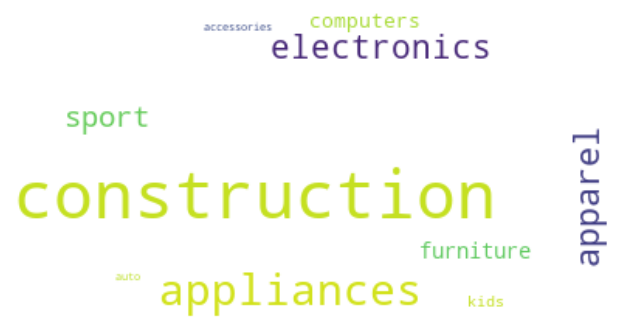

In [18]:
rows = df_top10.collect()
frequencies = {row['category']: row['sales_count'] for row in rows}

wc = WordCloud(background_color="white")
wc.generate_from_frequencies(frequencies)

fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(10)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [8]:
for row in df_top10.collect():
    print(row)

Row(category='construction', sales_count=513806)
Row(category='appliances', sales_count=163635)
Row(category='apparel', sales_count=91649)
Row(category='electronics', sales_count=84729)
Row(category='sport', sales_count=67901)
Row(category='furniture', sales_count=31466)
Row(category='computers', sales_count=26039)
Row(category='kids', sales_count=14424)
Row(category='accessories', sales_count=6276)
Row(category='auto', sales_count=5824)


In [9]:
df_sales = df.filter(col("event_type") == "view")

df_grouped = df_sales.groupBy("category").agg(count("id").alias("view_count"))

df_top10 = df_grouped.orderBy(col("view_count").desc()).limit(10)

df_top10.show()

+------------+----------+
|    category|view_count|
+------------+----------+
|construction|  15873789|
|  appliances|  10321246|
|     apparel|   6824523|
| electronics|   6237862|
|       sport|   2995544|
|   furniture|   2399403|
|   computers|   2388011|
|        kids|   1345026|
| accessories|    728651|
|        auto|    503282|
+------------+----------+



In [19]:
df_sales = df.filter(col("event_type") == "purchase")

df_grouped = df_sales.groupBy("brand").agg(count("id").alias("sales_count_brand"))

df_top10 = df_grouped.orderBy(col("sales_count_brand").desc()).limit(10)

df_top10.show()

+-------+-----------------+
|  brand|sales_count_brand|
+-------+-----------------+
|samsung|           265773|
|  apple|           209511|
| xiaomi|           101500|
| huawei|            45118|
|lucente|            21010|
|   oppo|            19843|
|   sony|            16526|
|     lg|            16191|
|  artel|             9211|
| lenovo|             8711|
+-------+-----------------+



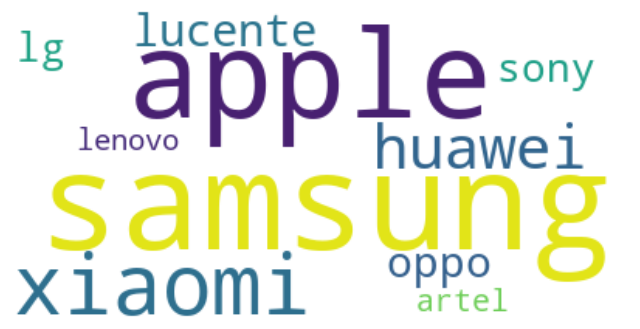

In [20]:
rows = df_top10.collect()
frequencies = {row['brand']: row['sales_count_brand'] for row in rows}

wc = WordCloud(background_color="white")
wc.generate_from_frequencies(frequencies)

fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(10)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
df_sales = df.filter(col("event_type") == "view")

df_grouped = df_sales.groupBy("brand").agg(count("id").alias("view_count_brand"))

df_top10 = df_grouped.orderBy(col("view_count_brand").desc()).limit(10)

df_top10.show()

+-------+----------------+
|  brand|view_count_brand|
+-------+----------------+
|samsung|         7563547|
|  apple|         4880173|
| xiaomi|         4738632|
| huawei|         1736478|
|lucente|         1159695|
|     lg|          878712|
|   sony|          844867|
|   oppo|          703464|
| lenovo|          601244|
|  bosch|          533426|
+-------+----------------+



### Question:
What was the period of time with most purchases?
- During which part of the month - beginning, mid, end

In [36]:
#  checking nr of purchases each day

purchases = df.filter(col("event_type") == "purchase")

daily_purchases = purchases.groupBy("day").count()
sorted_daily_purchases = daily_purchases.orderBy("day")

sorted_daily_purchases.show(n=sorted_daily_purchases.count())

+---+-----+
|day|count|
+---+-----+
|  1|24115|
|  2|24106|
|  3|20822|
|  4|20843|
|  5|21789|
|  6|23735|
|  7|23306|
|  8|22287|
|  9|23340|
| 10|23546|
| 11|22393|
| 12|22661|
| 13|23150|
| 14|22779|
| 15|30207|
| 16|55687|
| 17|44617|
| 18|42407|
| 19|41384|
| 20|39752|
| 21|37845|
| 22|38500|
| 23|40156|
| 24|38890|
| 25|38953|
| 26|38589|
| 27|38061|
| 28|39958|
| 29|43703|
| 30|45197|
| 31|34705|
+---+-----+



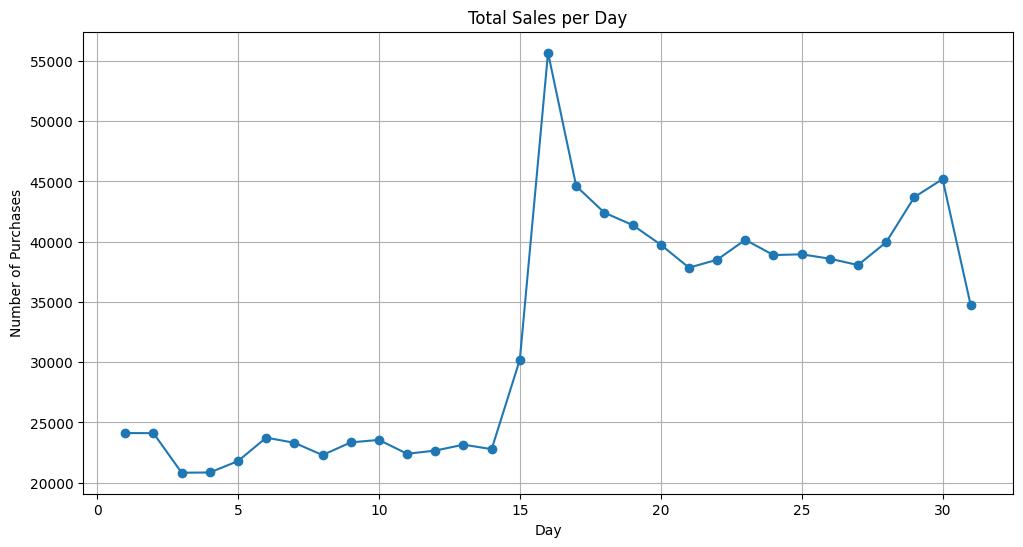

In [37]:
pandas_df = sorted_daily_purchases.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df['day'], pandas_df['count'], marker='o')
plt.title('Total Sales COUNT per Day')
plt.xlabel('Day')
plt.ylabel('Number of Purchases')
plt.grid(True)
plt.show()

In [41]:
purchases = df.filter(F.col("event_type") == "purchase")

daily_purchases_sum = purchases.groupBy("day").agg(F.sum("price").alias("total_sales"))

formatted_daily_purchases_sum = daily_purchases_sum.select(
    "day",
    F.format_number("total_sales", 2).alias("total_sales_formatted")
)
sorted_daily_purchases_sum = formatted_daily_purchases_sum.orderBy("day")
daily_ordered = daily_purchases_sum.orderBy("day")

sorted_daily_purchases_sum.show(n=sorted_daily_purchases_sum.count())

+---+---------------------+
|day|total_sales_formatted|
+---+---------------------+
|  1|         7,639,255.61|
|  2|         7,770,816.29|
|  3|         6,981,118.66|
|  4|         6,928,181.75|
|  5|         7,062,674.02|
|  6|         7,687,568.99|
|  7|         7,546,747.99|
|  8|         7,095,540.15|
|  9|         7,738,367.38|
| 10|         7,839,283.41|
| 11|         7,256,905.17|
| 12|         7,442,170.11|
| 13|         7,415,751.30|
| 14|         7,236,447.44|
| 15|        10,075,864.01|
| 16|        19,192,940.25|
| 17|        14,479,711.72|
| 18|        13,786,622.56|
| 19|        13,290,268.33|
| 20|        12,587,880.16|
| 21|        11,918,218.01|
| 22|        12,136,360.98|
| 23|        13,066,758.42|
| 24|        12,609,119.82|
| 25|        12,416,531.44|
| 26|        12,427,137.66|
| 27|        12,074,179.57|
| 28|        12,537,291.88|
| 29|        13,611,560.08|
| 30|        14,353,303.36|
| 31|        11,284,149.41|
+---+---------------------+



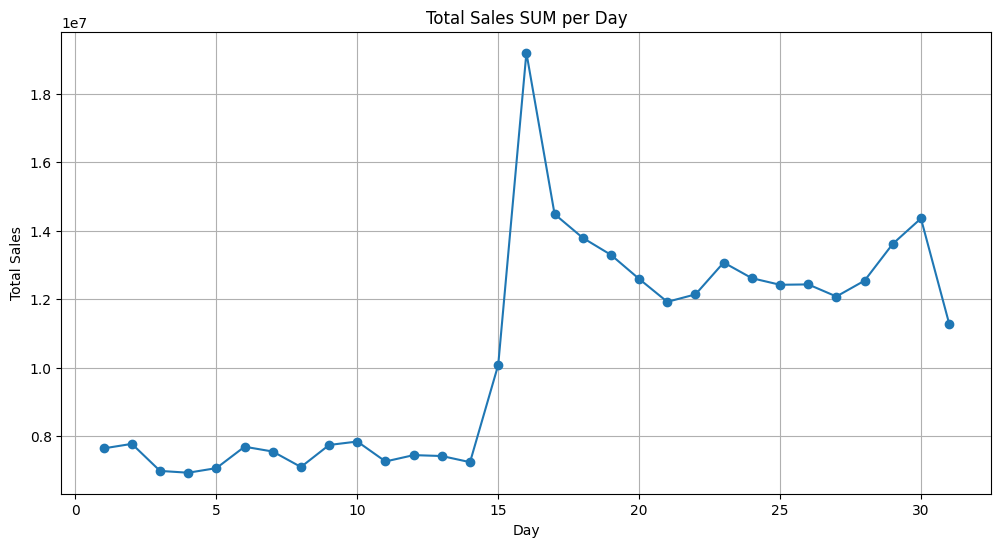

In [42]:
pandas_df = daily_ordered.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df['day'], pandas_df['total_sales'], marker='o')
plt.title('Total Sales SUM per Day')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


### Question:
Total price of sales for the month

In [45]:
total_sales_sum = daily_ordered.agg(F.sum("total_sales").alias("total_sales_sum"))

total_sales_sum_value = total_sales_sum.collect()[0]["total_sales_sum"]
formatted_total_sales_sum = f"{total_sales_sum_value:,.2f}"

print("Total Sales Sum:", formatted_total_sales_sum)

Total Sales Sum: 325,488,725.93
